# Park Factor Analysis
This notebook calculates and saves 1- and 3-year park factor datasets. The 3-year park factors include component-level effects and handedness splits. At the end, it inspects these effects for the 2019 season t see which stadiums have the most prominent effects. This serves as supporting analysis for a newsletter/blog post I'm writing for Baseball IQ (baseballiq.substack.com)

To replicate, you will need to get two datasets:
* git clone https://github.com/chadwickbureau/retrosplits (box score data that I'm using)
* the "people" file from the Lahman database. You can get this from the pybaseball python library, or download Lahman's database directly from his website.

Besides these two dataset dependencies, you should be able to run this end-to-end and it will save two park factor datasets into your current directory.

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Read and Prepare Data

In [2]:
# read lahman database's people file to get batter handedness
filename = '/Users/jamesledoux/Documents/baseballdatabank-master/core/People.csv'
people = read.csv(filename)

In [3]:
# to get this data:
# git clone https://github.com/chadwickbureau/retrosplits
# replace my file path with yours in this cell to get this to work

current_year = 2019
first_year = 1990

# read year one box score data, loop through the other years and concatenate those dataframes onto the original
# result is a single dataframe containing all seasons' data
first_year_filename = '/Users/jamesledoux/Documents/data/retrosplits/daybyday/playing-1999.csv'
df = read.csv(first_year_filename)
df$season = first_year

for (season_ in (first_year+1):2019)
{
    filename = paste0('/Users/jamesledoux/Documents/data/retrosplits/daybyday/playing-', as.character(season_), '.csv')
    df_new = read.csv(filename)
    df_new$season = season_
    df = rbind(df, df_new)

}

In [4]:
# join player features onto this dataset (used for batter handedness)
df$person.key = as.character(df$person.key)
people$playerID = as.character(people$playerID)
df = df %>% left_join(people, by=c("person.key"="retroID"))

In [5]:
# limit to just regular season, define singles
df = df %>% filter(season.phase=='R')
df = df %>% mutate(B_1B = B_H - B_2B - B_3B - B_HR)

In [6]:
# create home/away flag by finding most common stadium for each team
home_stadiums = df %>% group_by(team.key, season) %>% count(site.key) %>% top_n(1)
df = df %>% left_join(home_stadiums, by=c('team.key', 'season'), 
                 suffix=c('', '_homeflag')) %>% 
    mutate(home_or_away = ifelse(site.key==site.key_homeflag, 'home', 'away'))

Selecting by n



# Create Single Year Park Effects

In [7]:
# define handedness-split events (HR_R and HR_L in addition to the original HR column)
games = df %>% 
    mutate(
         B_HR_L = ifelse(bats=='L', B_HR, 0),
         B_1B_L = ifelse(bats=='L', B_1B, 0),
         B_2B_L = ifelse(bats=='L', B_2B, 0),
         B_3B_L = ifelse(bats=='L', B_3B, 0),
         B_BB_L = ifelse(bats=='L', B_BB, 0),
         B_IBB_L = ifelse(bats=='L', B_IBB, 0),
         B_HP_L = ifelse(bats=='L', B_HP, 0),
         B_R_L =  ifelse(bats=='L', B_R, 0),
         B_HR_R = ifelse(bats=='R', B_HR, 0),
         B_1B_R = ifelse(bats=='R', B_1B, 0),
         B_2B_R = ifelse(bats=='R', B_2B, 0),
         B_3B_R = ifelse(bats=='R', B_3B, 0),
         B_BB_R = ifelse(bats=='R', B_BB, 0),
         B_IBB_R = ifelse(bats=='R', B_IBB, 0), 
         B_HP_R = ifelse(bats=='R', B_HP, 0),
         B_R_R = ifelse(bats=='R', B_R, 0),
    ) 

# aggregate this into game-level statistics (we don't need person-level data to create a park factor)
games = games %>% 
    group_by(team.key, opponent.key, season, site.key, game.date, game.number, home_or_away) %>% 
                summarise(B_HR=sum(B_HR), 
                         B_1B = sum(B_1B),
                         B_2B = sum(B_2B),
                         B_3B = sum(B_3B),
                         B_BB = (sum(B_BB) - sum(B_IBB)),
                         B_HP = sum(B_HP),
                         B_XI = sum(B_XI),
                         B_R = sum(B_R),
                         B_HR_R=sum(B_HR_R), 
                         B_1B_R = sum(B_1B_R),
                         B_2B_R = sum(B_2B_R),
                         B_3B_R = sum(B_3B_R),
                         B_BB_R = (sum(B_BB_R) - sum(B_IBB_R)),
                         B_HP_R = sum(B_HP_R),
                         B_R_R = sum(B_R_R),
                         B_HR_L=sum(B_HR_L), 
                        B_1B_L = sum(B_1B_L),
                         B_2B_L = sum(B_2B_L),
                         B_3B_L = sum(B_3B_L),
                         B_BB_L = (sum(B_BB_L) - sum(B_IBB_L)),
                         B_HP_L = sum(B_HP_L),
                         B_R_L = sum(B_R_L),
                         games = n_distinct(team.key, opponent.key, season, 
                                            site.key, game.date, game.number, 
                                            home_or_away)) %>%
                ungroup()

`summarise()` regrouping output by 'team.key', 'opponent.key', 'season', 'site.key', 'game.date', 'game.number' (override with `.groups` argument)



In [8]:
# First create single-year effects, then do multi-year effects next
home = games %>% filter(home_or_away=='home') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number", "season"="season"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games),                     
                        games=sum(games)
                ) %>% ungroup()


away = games %>% filter(home_or_away=='away') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games), 
                        games=sum(games)
                ) %>% ungroup()


park_effects = home %>% left_join(away, by=c('team.key', 'season'), suffix=c('', '_road')) %>%
    mutate(
      B_R = B_R/B_R_road,
    )

`summarise()` regrouping output by 'season' (override with `.groups` argument)

`summarise()` regrouping output by 'season' (override with `.groups` argument)



In [9]:
# save single-season park effects dataset
park_effects %>% select(season, team.key, B_R) %>% write.csv('single_season_effects.csv')

In [10]:
#show the components of a single team's 2019 park factor. only using this to illustrate the guts of
#.   a park factor in the blog post.
games %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number", "season"="season"),
             suffix=c("","_opponent")) %>% 
    filter(team.key=='TEX', season==2019) %>% group_by(home_or_away) %>% 
    summarise(r = sum(B_R), ra = sum(B_R_opponent), g = sum(games))

`summarise()` ungrouping output (override with `.groups` argument)



home_or_away,r,ra,g
<chr>,<int>,<int>,<int>
away,356,396,81
home,454,482,81


# Create 3-Year Park Effects with Component Effects and Handedness Splits

In [11]:
#calculate three-year park effects
#shortcut to do this: create the previous two seasons' dataframes (season -= 1, season-=2)
#concatenate those onto the main dataframe. now season=2003 will include 2001, 2002, and 2003
# so: the 2003 season in this dataset will now represent three years of data for a 3-year 2003 park effect

# creating this in case i need to undo this later (filter for season==actual_season)
games = games %>% mutate(actual_season=season)

previous_year_games = games %>% mutate(season = season + 1)
two_years_ago_games = games %>% mutate(season = season + 2)

games = rbind(games, previous_year_games)
games = rbind(games, two_years_ago_games)

# remove illegal years (future years caused by my offsetting logic, years where three years of data aren't available)
games = games %>% filter(season <= current_year, season >= first_year+2)

In [12]:
# aggregate 3y park effect data to be game-level
games = games %>% 
    group_by(team.key, opponent.key, season, site.key, game.date, game.number, home_or_away) %>% 
                    summarise(B_HR=sum(B_HR), 
                             B_1B = sum(B_1B),
                             B_2B = sum(B_2B),
                             B_3B = sum(B_3B),
                             B_BB = sum(B_BB),
                             B_HP = sum(B_HP),
                             B_XI = sum(B_XI),
                             B_R = sum(B_R),
                             B_HR_R=sum(B_HR_R), 
                             B_1B_R = sum(B_1B_R),
                             B_2B_R = sum(B_2B_R),
                             B_3B_R = sum(B_3B_R),
                             B_BB_R = sum(B_BB_R),
                             B_HP_R = sum(B_HP_R),
                             B_R_R = sum(B_R_R),
                             B_HR_L=sum(B_HR_L), 
                             B_1B_L = sum(B_1B_L),
                             B_2B_L = sum(B_2B_L),
                             B_3B_L = sum(B_3B_L),
                             B_BB_L = sum(B_BB_L),
                             B_HP_L = sum(B_HP_L),
                             B_R_L = sum(B_R_L),
                             games = n_distinct(team.key, opponent.key, season, 
                                                site.key, game.date, game.number, 
                                                home_or_away)) %>%
                    ungroup()

`summarise()` regrouping output by 'team.key', 'opponent.key', 'season', 'site.key', 'game.date', 'game.number' (override with `.groups` argument)



In [13]:
# create the values needed to calculate park effects (home and opponent team stats for home and away games)
home = games %>% filter(home_or_away=='home') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number", "season"="season"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(B_HR=(sum(B_HR, na.rm=TRUE) + sum(B_HR_opponent, na.rm=TRUE))/sum(games), 
                         B_1B = (sum(B_1B, na.rm=TRUE) + sum(B_1B_opponent, na.rm=TRUE))/sum(games), 
                         B_2B = (sum(B_2B, na.rm=TRUE) + sum(B_2B_opponent, na.rm=TRUE))/sum(games), 
                         B_3B = (sum(B_3B, na.rm=TRUE) + sum(B_3B_opponent, na.rm=TRUE))/sum(games), 
                         B_BB = (sum(B_BB, na.rm=TRUE) + sum(B_BB_opponent, na.rm=TRUE))/sum(games), 
                         B_HP = (sum(B_HP, na.rm=TRUE) + sum(B_HP_opponent, na.rm=TRUE))/sum(games), 
                         B_XI = 1, #(sum(B_XI, na.rm=TRUE) + sum(B_XI_opponent, na.rm=TRUE))/sum(games), 
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_HR_R=(sum(B_HR_R, na.rm=TRUE) + sum(B_HR_R_opponent, na.rm=TRUE))/sum(games), 
                         B_1B_R = (sum(B_1B_R, na.rm=TRUE) + sum(B_1B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_2B_R = (sum(B_2B_R, na.rm=TRUE) + sum(B_2B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_3B_R = (sum(B_3B_R, na.rm=TRUE) + sum(B_3B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_BB_R = (sum(B_BB_R, na.rm=TRUE) + sum(B_BB_R_opponent, na.rm=TRUE))/sum(games), 
                         B_HP_R = (sum(B_HP_R, na.rm=TRUE) + sum(B_HP_R_opponent, na.rm=TRUE))/sum(games), 
                         B_R_R = (sum(B_R_R, na.rm=TRUE) + sum(B_R_R_opponent, na.rm=TRUE))/sum(games),  
                         B_HR_L=(sum(B_HR_L, na.rm=TRUE) + sum(B_HR_L_opponent, na.rm=TRUE))/sum(games), 
                         B_1B_L = (sum(B_1B_L, na.rm=TRUE) + sum(B_1B_L_opponent, na.rm=TRUE))/sum(games), 
                         B_2B_L = (sum(B_2B_L, na.rm=TRUE) + sum(B_2B_L_opponent, na.rm=TRUE))/sum(games), 
                         B_3B_L = (sum(B_3B_L, na.rm=TRUE) + sum(B_3B_L_opponent, na.rm=TRUE))/sum(games), 
                         B_BB_L = (sum(B_BB_L, na.rm=TRUE) + sum(B_BB_L_opponent, na.rm=TRUE))/sum(games), 
                         B_HP_L = (sum(B_HP_L, na.rm=TRUE) + sum(B_HP_L_opponent, na.rm=TRUE))/sum(games), 
                         B_R_L = (sum(B_R_L, na.rm=TRUE) + sum(B_R_L_opponent, na.rm=TRUE))/sum(games), 
                        games=sum(games)
                ) %>% ungroup()


away = games %>% filter(home_or_away=='away') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(B_HR=(sum(B_HR, na.rm=TRUE) + sum(B_HR_opponent, na.rm=TRUE))/sum(games), 
                         B_1B = (sum(B_1B, na.rm=TRUE) + sum(B_1B_opponent, na.rm=TRUE))/sum(games), 
                         B_2B = (sum(B_2B, na.rm=TRUE) + sum(B_2B_opponent, na.rm=TRUE))/sum(games), 
                         B_3B = (sum(B_3B, na.rm=TRUE) + sum(B_3B_opponent, na.rm=TRUE))/sum(games), 
                         B_BB = (sum(B_BB, na.rm=TRUE) + sum(B_BB_opponent, na.rm=TRUE))/sum(games), 
                         B_HP = (sum(B_HP, na.rm=TRUE) + sum(B_HP_opponent, na.rm=TRUE))/sum(games), 
                         B_XI = 1, #(sum(B_XI, na.rm=TRUE) + sum(B_XI_opponent, na.rm=TRUE))/sum(games), 
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_HR_R=(sum(B_HR_R, na.rm=TRUE) + sum(B_HR_R_opponent, na.rm=TRUE))/sum(games), 
                         B_1B_R = (sum(B_1B_R, na.rm=TRUE) + sum(B_1B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_2B_R = (sum(B_2B_R, na.rm=TRUE) + sum(B_2B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_3B_R = (sum(B_3B_R, na.rm=TRUE) + sum(B_3B_R_opponent, na.rm=TRUE))/sum(games), 
                         B_BB_R = (sum(B_BB_R, na.rm=TRUE) + sum(B_BB_R_opponent, na.rm=TRUE))/sum(games), 
                         B_HP_R = (sum(B_HP_R, na.rm=TRUE) + sum(B_HP_R_opponent, na.rm=TRUE))/sum(games), 
                         B_R_R = (sum(B_R_R, na.rm=TRUE) + sum(B_R_R_opponent, na.rm=TRUE))/sum(games),  
                         B_HR_L=(sum(B_HR_L, na.rm=TRUE) + sum(B_HR_L_opponent, na.rm=TRUE))/sum(games), 
                         B_1B_L = (sum(B_1B_L, na.rm=TRUE) + sum(B_1B_L_opponent, na.rm=TRUE))/sum(games), 
                         B_2B_L = (sum(B_2B_L, na.rm=TRUE) + sum(B_2B_L_opponent, na.rm=TRUE))/sum(games), 
                         B_3B_L = (sum(B_3B_L, na.rm=TRUE) + sum(B_3B_L_opponent, na.rm=TRUE))/sum(games), 
                         B_BB_L = (sum(B_BB_L, na.rm=TRUE) + sum(B_BB_L_opponent, na.rm=TRUE))/sum(games), 
                         B_HP_L = (sum(B_HP_L, na.rm=TRUE) + sum(B_HP_L_opponent, na.rm=TRUE))/sum(games), 
                         B_R_L = (sum(B_R_L, na.rm=TRUE) + sum(B_R_L_opponent, na.rm=TRUE))/sum(games), 
                        games=sum(games)
                ) %>% ungroup()

`summarise()` regrouping output by 'season' (override with `.groups` argument)

`summarise()` regrouping output by 'season' (override with `.groups` argument)



In [14]:
# calculate final park effects for R, components, handedness-split components
park_effects = home %>% left_join(away, by=c('team.key', 'season'), suffix=c('', '_road')) %>%
    mutate(
      B_HR = B_HR/B_HR_road, 
      B_1B = B_1B/B_1B_road,
      B_2B = B_2B/B_2B_road,
      B_3B = B_3B/B_3B_road,
      B_BB = B_BB/B_BB_road,
      B_HP = B_HP/B_HP_road,
      B_R = B_R/B_R_road,
      B_HR_L = B_HR_L/B_HR_L_road, 
      B_1B_L = B_1B_L/B_1B_road,
      B_2B_L = B_2B_L/B_2B_L_road,
      B_3B_L = B_3B_L/B_3B_L_road,
      B_BB_L = B_BB_L/B_BB_L_road,
      B_HP_L = B_HP_L/B_HP_L_road,
      B_R_L = B_R_L/B_R_L_road,
      B_HR_R = B_HR_R/B_HR_R_road, 
      B_1B_R = B_1B_R/B_1B_R_road,
      B_2B_R = B_2B_R/B_2B_R_road,
      B_3B_R = B_3B_R/B_3B_R_road,
      B_BB_R = B_BB_R/B_BB_R_road,
      B_HP_R = B_HP_R/B_HP_R_road,
      B_R_R =  B_R_R/B_R_R_road
    )

In [15]:
# save 3y, component-level, handedness-split park effects dataset
park_effects %>% write.csv('3y_park_effects_with_components_and_handedness.csv')

# Inspect Results

In [16]:
# calculate some handedness splits
park_effects = park_effects %>% mutate(run_diff = B_R_R - B_R_L,
                                       hr_diff = B_HR_R - B_HR_L)

In [17]:
# inspect park effects
park_effects %>% filter(season==2019) %>% arrange(-B_R) %>% select(team.key, B_R)

team.key,B_R
<chr>,<dbl>
COL,1.3579232
TEX,1.2750175
WAS,1.1054224
ARI,1.1043755
PHI,1.0669938
DET,1.0653740
BOS,1.0639133
CHN,1.0613939
MIN,1.0517724


In [18]:
park_effects %>% filter(season==2019) %>% arrange(-B_R) %>% select(!matches("_road"))

season,team.key,B_HR,B_1B,B_2B,B_3B,B_BB,B_HP,B_XI,B_R,⋯,B_HR_L,B_1B_L,B_2B_L,B_3B_L,B_BB_L,B_HP_L,B_R_L,games,run_diff,hr_diff
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
2019,COL,1.2994432,1.1463472,1.3230695,2.1397217,1.0633859,0.9458118,1,1.3579232,⋯,1.4143989,0.4569950,1.3627278,2.4362140,1.1003505,0.8530536,1.3695272,243,0.0205797698,-0.1527791291
2019,TEX,1.1589242,1.1391375,1.1746835,1.6134454,1.1480342,1.0930233,1,1.2750175,⋯,1.1474104,0.3917819,1.1657559,1.4883721,1.1817384,1.5213675,1.3594164,243,-0.1772944740,-0.0627708601
2019,WAS,1.1513561,1.0843325,1.1528662,0.7415730,0.9906542,1.0173410,1,1.1054224,⋯,1.0454545,0.3633094,1.2165725,0.5846154,1.0217202,0.8907563,1.0748731,243,0.0502394148,0.1565322095
2019,ARI,1.0598749,1.0107698,1.1242830,1.6196319,1.0030211,1.0957096,1,1.1043755,⋯,1.0267062,0.3434384,1.1626898,1.6206897,0.8859060,0.8347826,1.0526316,243,0.0422390520,0.0002398763
2019,PHI,1.3190974,0.9573947,0.9302612,0.9425081,1.0508965,1.0253537,1,1.0669938,⋯,1.2769424,0.2880756,0.9040895,0.8599903,1.0146865,1.4370666,1.0218994,242,0.0723944979,0.0549394280
2019,DET,1.0403329,1.0659251,1.0507153,1.5249457,0.9645830,1.0595438,1,1.0653740,⋯,0.9515265,0.2320281,1.0010512,1.8671180,1.1567439,1.2255433,1.0629583,243,0.0033363234,0.1421487702
2019,BOS,0.9097360,1.0253552,1.2916574,1.0842993,0.9946972,0.9739311,1,1.0639133,⋯,0.8976870,0.3272330,1.7119578,1.3964802,1.0182226,1.0124481,1.1130684,241,-0.0656546820,0.0614743795
2019,CHN,0.9832740,1.0085847,1.0318194,1.3084839,1.0397188,1.0591707,1,1.0613939,⋯,0.9260954,0.3373307,1.2448770,1.3985002,1.0212642,1.2228159,1.1059422,244,-0.0441286619,0.1842580076
2019,MIN,1.0279290,1.0228842,1.1234799,1.1295528,1.0619936,1.0867077,1,1.0517724,⋯,1.0215565,0.3465085,0.9943861,1.5587828,1.0125554,1.0549597,1.0146438,241,0.0896165105,0.0530848913


In [19]:
# inspect component effects vs. overall effect
park_effects %>% filter(season==2019) %>% arrange(-B_R) %>% 
    select(team.key, B_1B, B_2B, B_3B, B_HR, B_R)

team.key,B_1B,B_2B,B_3B,B_HR,B_R
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL,1.1463472,1.3230695,2.1397217,1.2994432,1.3579232
TEX,1.1391375,1.1746835,1.6134454,1.1589242,1.2750175
WAS,1.0843325,1.1528662,0.7415730,1.1513561,1.1054224
ARI,1.0107698,1.1242830,1.6196319,1.0598749,1.1043755
PHI,0.9573947,0.9302612,0.9425081,1.3190974,1.0669938
DET,1.0659251,1.0507153,1.5249457,1.0403329,1.0653740
BOS,1.0253552,1.2916574,1.0842993,0.9097360,1.0639133
CHN,1.0085847,1.0318194,1.3084839,0.9832740,1.0613939
MIN,1.0228842,1.1234799,1.1295528,1.0279290,1.0517724


In [20]:
# look at home run handedness splits 
# for ref/qa http://www.espn.com/mlb/stats/parkfactor/_/year/2019/sort/HRFactor
park_effects %>% filter(season==2019) %>% select(
    team.key, B_R, B_HR, B_HR_R, B_HR_L, hr_diff) %>% 
    arrange(-B_R)

team.key,B_R,B_HR,B_HR_R,B_HR_L,hr_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL,1.3579232,1.2994432,1.2616197,1.4143989,-0.1527791291
TEX,1.2750175,1.1589242,1.0846395,1.1474104,-0.0627708601
WAS,1.1054224,1.1513561,1.2019868,1.0454545,0.1565322095
ARI,1.1043755,1.0598749,1.0269461,1.0267062,0.0002398763
PHI,1.0669938,1.3190974,1.3318818,1.2769424,0.0549394280
DET,1.0653740,1.0403329,1.0936752,0.9515265,0.1421487702
BOS,1.0639133,0.9097360,0.9591614,0.8976870,0.0614743795
CHN,1.0613939,0.9832740,1.1103535,0.9260954,0.1842580076
MIN,1.0517724,1.0279290,1.0746414,1.0215565,0.0530848913


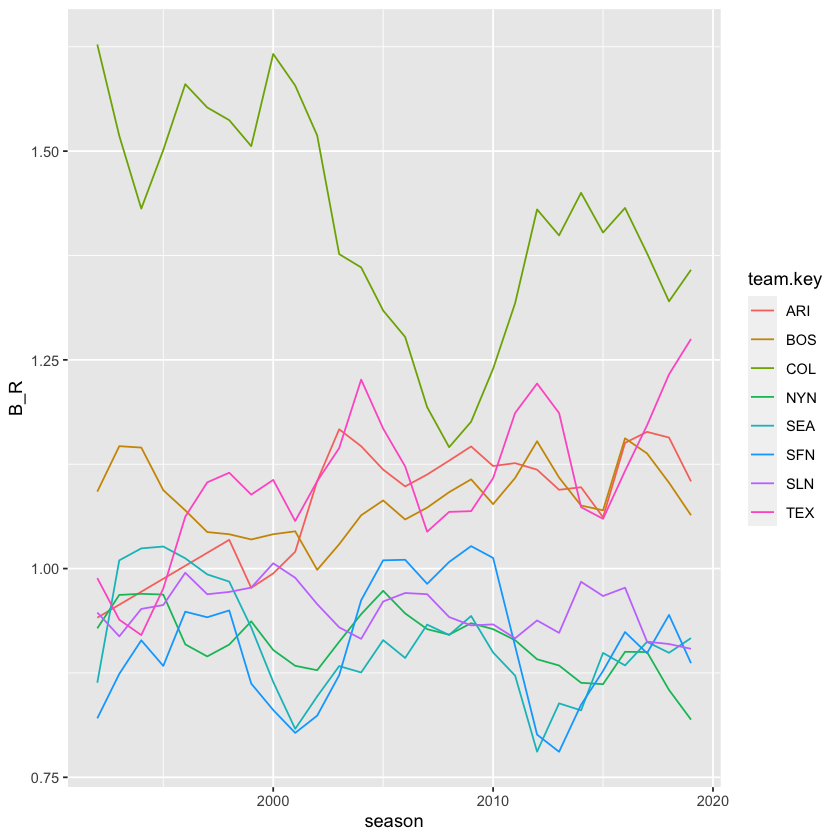

In [21]:
# they're semi-consistent over time. some changes are hard to explain (Coors took a tank in the mid-2000s). Some 
#.    have good reasons for movement (TEX got higher in the mid-90s because they moved to a new stadium.)
park_effects %>% filter(team.key %in% c('COL', 'ARI', 'TEX', 'NYN', 'BOS', 'SFN', 'SEA', 'SLN')) %>%
    ggplot() + geom_line(aes(x=season, y=B_R, color=team.key))

In [22]:
df = df %>% mutate(
    woba_numerator = 0.9*B_1B + 1.24*B_2B + 1.56*B_3B + 1.95*B_HR + 0.72*(B_BB - B_IBB) + 0.75*B_HP +  0.92*B_XI, # the book's weights
    woba_denominator = B_PA)

In [23]:
players = df %>% group_by(season, person.key, team.key, home_or_away) %>%
    summarise(woba = sum(woba_numerator)/sum(woba_denominator), pa=sum(B_PA))

`summarise()` regrouping output by 'season', 'person.key', 'team.key' (override with `.groups` argument)



In [26]:
df %>% select(-B_R) %>%
    filter(season==2019) %>%
    left_join(park_effects, 
              by = c("team.key" = "team.key", "season" = "season")) %>%
    group_by(team.key, home_or_away, B_R) %>%
    summarise(woba = sum(woba_numerator)/sum(woba_denominator)) %>% 
    select(team.key, home_or_away, woba, B_R)
    

`summarise()` regrouping output by 'team.key', 'home_or_away' (override with `.groups` argument)



team.key,home_or_away,woba,B_R
<chr>,<chr>,<dbl>,<dbl>
ANA,away,0.3213350,0.9905805
ANA,home,0.3276385,0.9905805
ARI,away,0.3281748,1.1043755
ARI,home,0.3205260,1.1043755
ATL,away,0.3276728,1.0307213
ATL,home,0.3485532,1.0307213
BAL,away,0.3064876,1.0411251
BAL,home,0.3232895,1.0411251
BOS,away,0.3375170,1.0639133


In [27]:
players %>% 
    left_join(park_effects %>% mutate(team.key=as.character(team.key)), 
              by = c("team.key" = "team.key", "season" = "season")) %>% 
    select(person.key, team.key, home_or_away, pa, woba, B_R) %>% 
    filter(season==2019, 
           person.key %in% c('blacc001', 'brega001', 'arenn001', 'muncm001', 'adamw002', 'choos001')) %>%
          arrange(team.key, person.key, home_or_away)

Adding missing grouping variables: `season`



season,person.key,team.key,home_or_away,pa,woba,B_R
<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
2019,arenn001,COL,away,327,0.3581346,1.3579232
2019,arenn001,COL,home,335,0.4299104,1.3579232
2019,blacc001,COL,away,328,0.3158537,1.3579232
2019,blacc001,COL,home,306,0.4821242,1.3579232
2019,brega001,HOU,away,345,0.4602319,0.9306612
2019,brega001,HOU,home,345,0.3964058,0.9306612
2019,muncm001,LAN,away,305,0.4001311,0.9353772
2019,muncm001,LAN,home,284,0.3617254,0.9353772
2019,adamw002,TBA,away,306,0.3836601,0.9239888
